In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

In [9]:
df = pd.read_csv('final_df.csv')\
    .drop(columns=['Unnamed: 0'])
df.head()

,embedding0,embedding1,embedding2,embedding3,embedding4,embedding5,embedding6,embedding7,embedding8,embedding9,...,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART,MISC,PER,numeric,currency,cat
0,0.632665,-1.215178,-0.104216,0.463468,-0.726552,0.387219,-0.510932,1.002295,-0.287655,-0.149799,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
1,0.188070,-0.527381,0.313595,1.068893,0.228069,-0.024379,-0.058320,0.662715,0.600098,0.001870,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
2,-0.592932,-0.157562,1.081982,-0.462546,2.084047,-1.003442,1.053524,-1.393904,-1.462139,-1.641344,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.090909,0.090909,0.0,0
3,0.829920,-0.707180,-0.266944,-0.445869,0.180606,-0.583575,-0.323159,-0.396419,-0.149665,0.240361,...,0.037037,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
4,-0.957458,-1.564864,-0.149202,-0.287992,0.825835,0.214527,0.519019,-0.614275,-0.015964,0.082642,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, random_state=1)

- https://scikit-learn.org/stable/modules/grid_search.html

In [11]:
import scipy
from sklearn.model_selection import ParameterSampler

In [30]:
n_estimators = np.array( [20, 50, 80] )
f_scores_macro = []
f_scores_micro = []

for est in n_estimators:
    rf = RandomForestClassifier(
        n_estimators=est,
        n_jobs=-1
    )

    print(f'Started fitting {est}')
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict( X_test )
    
    f_score_est = f1_score( y_test, y_pred, average='macro' )
    f_scores_macro.append( f_score_est )
    
    print( '-- F score macro:', f_score_est )

    f_score_est = f1_score( y_test, y_pred, average='micro' )
    f_scores_micro.append( f_score_est )

    print( '-- F score micro:', f_score_est )

Started fitting 20
-- F score macro: 0.3577039707566975
-- F score micro: 0.7040246316252474
Started fitting 50
-- F score macro: 0.35938485536340575
-- F score micro: 0.723334066417418
Started fitting 80
-- F score macro: 0.36332944362266767
-- F score micro: 0.7324829557950296


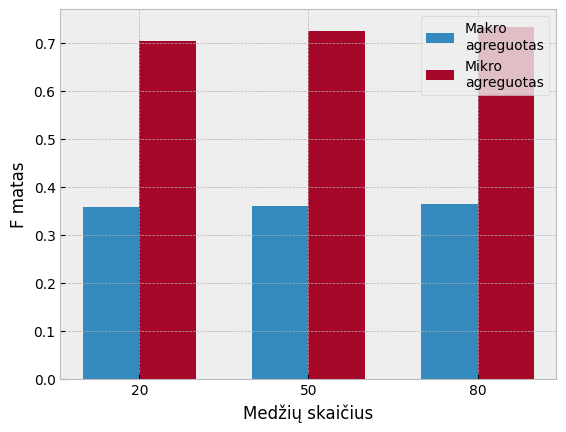

In [31]:
plt.style.use('bmh')

plt.bar(n_estimators - 5, f_scores_macro, width=10, label='Makro\nagreguotas')
plt.bar(n_estimators + 5, f_scores_micro, width=10, label='Mikro\nagreguotas')

plt.xticks(
    n_estimators, n_estimators
)

plt.xlabel('Medžių skaičius')
plt.ylabel('F matas')

plt.legend()

In [43]:
confusion_matrix(y_test, y_pred)

array([[    2,    15,     0,     0,    20,     0],
       [    0, 10707,     0,     4,  1355,     8],
       [    0,   110,     3,     2,   116,     0],
       [    0,   176,     0,   245,   321,     0],
       [    0,  2762,     0,     5,  5658,     2],
       [    0,   980,     0,     0,   206,    38]])

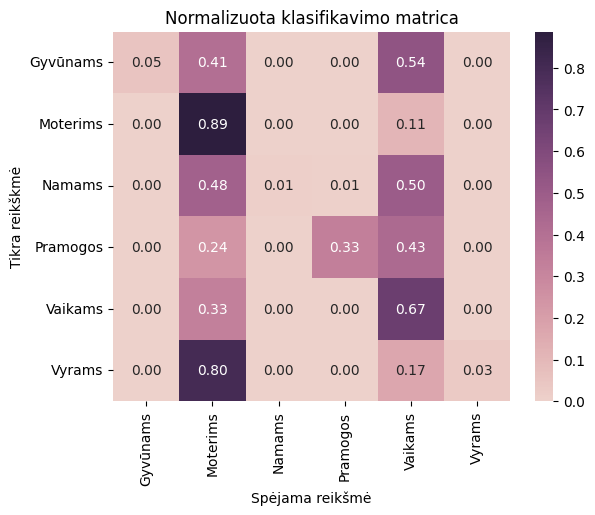

In [47]:
plt.style.use('default')

conf_mat = confusion_matrix(y_test, y_pred).astype(float)
conf_mat /= conf_mat.sum(axis=1, keepdims=True)

labels = ["Gyvūnams", "Moterims", "Namams", "Pramogos", "Vaikams", "Vyrams"]

sns.heatmap(
    conf_mat,
    annot=True,
    fmt='.2f',
    cmap=sns.cubehelix_palette(as_cmap=True),
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Spėjama reikšmė")
plt.ylabel("Tikra reikškmė")
plt.title("Normalizuota klasifikavimo matrica")
plt.savefig("randomized_forest_conf_mat.svg", format="svg", bbox_inches="tight")
plt.show()

In [ ]:
param_dist = {
    'learning_rate': scipy.stats.expon(scale=.1),
    'max_depth': [4, 8, 16],
    'n_estimators': [200, 250, 300]
}

best_params = None
best_fscore = 0.0

for params in ParameterSampler(param_dist, n_iter=4, random_state=42):

    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=6,
        **params
    )

    print('Started:', params)

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    f_score_iter = f1_score(y_test, y_pred, average="macro")

    if f_score_iter > best_fscore:
        best_fscore = f_score_iter
        best_params = params

    print('Parametrai:', params, '\nF matas:', f_score_iter)

Started: {'learning_rate': np.float64(0.04692680899768591), 'max_depth': 2, 'n_estimators': 200}
Parametrai: {'learning_rate': np.float64(0.04692680899768591), 'max_depth': 2, 'n_estimators': 200} 
F matas: 0.31222650389847595
Started: {'learning_rate': np.float64(0.13167456935454494), 'max_depth': 2, 'n_estimators': 100}
Parametrai: {'learning_rate': np.float64(0.13167456935454494), 'max_depth': 2, 'n_estimators': 100} 
F matas: 0.3680517027928036
Started: {'learning_rate': np.float64(0.01696248704623463), 'max_depth': 8, 'n_estimators': 200}
Parametrai: {'learning_rate': np.float64(0.01696248704623463), 'max_depth': 8, 'n_estimators': 200} 
F matas: 0.41102755442102135
Started: {'learning_rate': np.float64(0.005983876860868068), 'max_depth': 16, 'n_estimators': 100}


In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=6,
    **best_params
)

In [ ]:
y_pred = xgb_model.predict(X_test)

print('Accuracy:', accuracy_score( y_test, y_pred ) )
print('Recall:', recall_score( y_test, y_pred, average=None ))
print(

In [ ]:
f1_score( y_test, y_pred, average='micro' )